In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import wandb
from Levenshtein import distance
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import time
import math
import argparse
from types import SimpleNamespace
from copy import deepcopy
import itertools

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device = ", device)

# Paste your own key
wandb.login()

SOS_token = "@"
EOS_token = "#"
PAD_token = "^"
UNK_token = "$"

SOS_idx = 0
EOS_idx = 1
PAD_idx = 2
UNK_idx = 3

batch_size = 32
languages = ["asm", "ben", "brx", "guj", "hin", "kan", "kas", "kok", "mai", "mal", "mar", "mni", "ori", "pan", "san", "sid", "tam", "tel", "urd"]
best_model_path = '/kaggle/working/best_model_attn.pth'
test_pred_path = '/kaggle/working/pred_attn.csv'

Device =  cuda


In [37]:
def timeInMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    s = format(s, ".0f")
    return str(m) + "m " + str(s) + "s"

In [38]:
class Script:
    def __init__(self, name):
        self.name = name
        self.char2index = {SOS_token: SOS_idx, EOS_token: EOS_idx, PAD_token: PAD_idx, UNK_token: UNK_idx}
        self.char2count = {}
        self.index2char = {SOS_idx: SOS_token, EOS_idx: EOS_token, PAD_idx: PAD_token, UNK_idx: UNK_token}
        self.n_chars = 4  # Count SOS, EOS, PAD and UNK

    def addWord(self, word):
        for char in word:
            self.addChar(char)

    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

In [39]:
def prepareVocab(data, in_scr="lat", out_scr="dev"):
    input_vocab = Script(in_scr)
    output_vocab = Script(out_scr)
    
    for pair in data:
        input_vocab.addWord(pair[0])
        output_vocab.addWord(pair[1])
    
    return input_vocab, output_vocab

def tensorFromWord(word, vocab, sos=False, eos=False):
    char_list = []
    if sos:
        char_list.append(vocab.char2index[SOS_token])
    for char in word:
        if char in vocab.char2index:
            char_list.append(vocab.char2index[char])
        else:
            char_list.append(vocab.char2index[UNK_token])
    if eos:
        char_list.append(vocab.char2index[EOS_token])
    char_tensor = torch.tensor(char_list, dtype=torch.long)
    return char_tensor

def processData(data, vocab, sos=False, eos=False):
    tensor_list = []
    for word in data:
        word_tensor = tensorFromWord(word, vocab, sos, eos)
        tensor_list.append(word_tensor)
    word_tensor_pad = pad_sequence(tensor_list, padding_value=PAD_idx, batch_first=True)
    return word_tensor_pad

def wordFromTensor(word_tensor, vocab):
    word = ""
    for idx in word_tensor:
        if idx == EOS_idx:
            break
        if idx >= UNK_idx:
            word += vocab.index2char[idx.item()]
    return word

In [40]:
class Encoder(nn.Module):
    def __init__(self, cell_type, input_size, embedding_size, hidden_size, num_layers, dp, bidir=False):
        super(Encoder, self).__init__()
        self.cell_type = cell_type
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(dp)
        self.bidir = bidir
        
        self.embedding = nn.Embedding(self.input_size, self.embedding_size)
        if self.num_layers == 1:
            dp = 0.0
        if self.cell_type == "RNN":
            self.cell = nn.RNN(self.embedding_size, self.hidden_size, self.num_layers, dropout=dp, bidirectional=self.bidir)
        elif self.cell_type == "GRU":
            self.cell = nn.GRU(self.embedding_size, self.hidden_size, self.num_layers, dropout=dp, bidirectional=self.bidir)
        elif self.cell_type == "LSTM":
            self.cell = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, dropout=dp, bidirectional=self.bidir)

    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)
        
        cell = None
        if self.cell_type == "LSTM":
            outputs, (hidden, cell) = self.cell(embedding)
            if self.bidir:
                b_sz = cell.size(1)
                cell = cell.view(self.num_layers, 2, b_sz, -1)
                cell = cell[-1]
                cell = cell.mean(axis=0)
            else:
                cell = cell[-1,:,:]
            cell = cell.unsqueeze(0)
        else:
            outputs, hidden = self.cell(embedding)
        
        if self.bidir:
            b_sz = hidden.size(1)
            hidden = hidden.view(self.num_layers, 2, b_sz, -1)
            hidden = hidden[-1]
            hidden = hidden.mean(axis=0)
            outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        else:
            hidden = hidden[-1,:,:]
        hidden = hidden.unsqueeze(0)
        # outputs shape: (seq_length, N, hidden_size)

        return outputs, hidden, cell

In [41]:
class AttnDecoder(nn.Module):
    def __init__(
        self, cell_type, input_size, embedding_size, hidden_size, output_size, num_layers, dp
    ):
        super(AttnDecoder, self).__init__()
        self.cell_type = cell_type
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.attn_fc = nn.Linear(hidden_size, hidden_size, bias=False)
        self.dropout = nn.Dropout(dp)

        self.embedding = nn.Embedding(self.input_size, self.embedding_size)
        if self.num_layers == 1:
            dp = 0.0
        if self.cell_type == "RNN":
            self.cell = nn.RNN(self.embedding_size + self.hidden_size, self.hidden_size, self.num_layers, dropout=dp)
        elif self.cell_type == "GRU":
            self.cell = nn.GRU(self.embedding_size + self.hidden_size, self.hidden_size, self.num_layers, dropout=dp)
        elif self.cell_type == "LSTM":
            self.cell = nn.LSTM(self.embedding_size + self.hidden_size, self.hidden_size, self.num_layers, dropout=dp)
        self.fc = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, x, enc_out, hidden, cell):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(0)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)
        
        #---------------------------------------
        #Attention - Generate attn_w,context from enc_out,hidden
        enc_out_fc = self.attn_fc(enc_out) # (seq_len, b_sz, h_sz)
        last_hidden = hidden[-1:] # (1, b_sz, h_sz)
        score = enc_out_fc.permute(1, 0, 2) @ last_hidden.permute(1, 2, 0) # (b_sz, seq_len, 1)
        score = score.permute(2, 0, 1) # (1, b_sz, seq_len)
        attn_w = F.softmax(score, dim=2) # (1, b_sz, seq_len)
        context = attn_w.permute(1, 0, 2) @ enc_out.permute(1, 0, 2) # (b_sz, 1, h_sz)
        context = context.permute(1, 0, 2) # (1, b_sz, h_sz)
        #----------------------------------------
        
        if self.cell_type == "LSTM":
            outputs, (hidden, cell) = self.cell(torch.cat([embedding, context], dim=2), (hidden, cell))
        else:
            outputs, hidden = self.cell(torch.cat([embedding, context], dim=2), hidden)
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(torch.cat([outputs, context], dim=2))

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(0)
        attn_w = attn_w.squeeze(0)

        return predictions, hidden, cell, attn_w

In [42]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_sz = source.shape[1]
        source_len = source.shape[0]
        target_len = target.shape[0]
        target_vocab_size = self.decoder.output_size

        outputs = torch.zeros(target_len, batch_sz, target_vocab_size).to(device)

        enc_out, hidden, cell = self.encoder(source)
        hidden = hidden.repeat(self.decoder.num_layers,1,1)
        if self.decoder.cell_type == "LSTM":
            cell = cell.repeat(self.decoder.num_layers,1,1)
            
        attn_matrix = torch.zeros(target_len, batch_sz, source_len).to(device) # (target_len, b_sz, source_len)

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[0]

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            output, hidden, cell, attn_w = self.decoder(x, enc_out, hidden, cell)

            # Store next output prediction
            outputs[t] = output
            attn_matrix[t] = attn_w

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(dim=1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs, attn_matrix

In [43]:
def sum_accuracy(preds, target):
    num_equal_columns = torch.logical_or(preds == target, target == PAD_idx).all(dim=0).sum().item()
    return num_equal_columns

In [44]:
def plotAttn(model, input_seq, target_seq, src_vocab, tgt_vocab):
    model.eval()
    
    b_sz = input_seq.size(0)
    max_src_len = input_seq.size(1)
    max_tgt_len = target_seq.size(1)
    
    with torch.no_grad():
        # Get input and targets and get to cuda
        input_seq = input_seq.T.to(device)
        target_seq = target_seq.T.to(device)

        # Forward prop
        output, attn_matrix = model(input_seq, target_seq, teacher_force_ratio=0.0)
        
        output = output[1:]
        attn_matrix = attn_matrix[1:]
        pred_seq = output.argmax(dim=2)
        
        attn_matrix = attn_matrix.permute(1, 0, 2)
        input_seq = input_seq.T
        pred_seq = pred_seq.T
        
        fig, axes = plt.subplots(3, 3, figsize=(15,15))
        fig.text(0.5, 0.04, 'Decoder Output', ha='center', size=14)
        fig.text(0.04, 0.5, 'Encoder Input', va='center', rotation='vertical', size=14)
        fig.suptitle("Attention Heatmaps", fontsize=16)
        fig.tight_layout(pad=5.0)
        fig.subplots_adjust(top=0.90)

        font_prop = FontProperties(fname='/kaggle/input/mangal-font/Mangal.TTF')
        
        axes = axes.ravel()
        for i in range(b_sz):
            src_len = max_src_len
            pred_len = max_tgt_len - 1
            
            for j in range(max_src_len):
                if input_seq[i][j].item() == EOS_idx:
                    src_len = j+1
                    break
            
            for j in range(max_tgt_len - 1):
                if pred_seq[i][j].item() == EOS_idx:
                    pred_len = j+1
                    break
                    
            local_attn = attn_matrix[i]
            local_attn = local_attn[:pred_len]
            local_attn = local_attn[:, :src_len]
            local_attn = local_attn.T
            local_attn = local_attn.cpu()
            
            xticklabels = []
            for j in range(pred_len):
                xticklabels.append(tgt_vocab.index2char[pred_seq[i][j].item()])
#             xticklabels.append('<e>')
            yticklabels = []
            for j in range(src_len):
                yticklabels.append(src_vocab.index2char[input_seq[i][j].item()])
#             yticklabels.append('<e>')
            sns.heatmap(local_attn, ax=axes[i], cmap='magma', cbar=False, vmin=0.0, vmax=1.0)
            axes[i].set(xticks=[n for n in range(pred_len)], yticks=[n for n in range(src_len)])
            axes[i].set_yticklabels(yticklabels, rotation=10, fontdict={'fontsize':12})  
            axes[i].set_xticklabels(xticklabels, fontproperties = font_prop, fontdict={'fontsize':12})
            axes[i].xaxis.tick_top()
#         plt.tight_layout()
        plt.savefig('/kaggle/working/attn_hmap.png')
        wandb.log({'Attention Heatmap' : wandb.Image(plt)})
        
        return

In [45]:
def evaluateModel(model, dataloader, criterion, b_sz=32):
    model.eval()
    
    n_data = len(dataloader) * b_sz
    loss_epoch = 0
    n_correct = 0
    
    with torch.no_grad():
        for batch_idx, (input_seq, target_seq) in enumerate(dataloader):
            # Get input and targets and get to cuda
            input_seq = input_seq.T.to(device)
            target_seq = target_seq.T.to(device)

            # Forward prop
            output, attn_matrix = model(input_seq, target_seq, teacher_force_ratio=0.0)
            
            pred_seq = output.argmax(dim=2)
            n_correct += sum_accuracy(pred_seq, target_seq)

            # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
            # doesn't take input in that form. For example if we have MNIST we want to have
            # output to be: (N, 10) and targets just (N). Here we can view it in a similar
            # way that we have output_words * batch_size that we want to send in into
            # our cost function, so we need to do some reshapin. While we're at it
            # Let's also remove the start token while we're at it
            output = output[1:].reshape(-1, output.shape[2])
            target = target_seq[1:].reshape(-1)
            
            loss = criterion(output, target)

            loss_epoch += loss.item()
        
        acc = n_correct / n_data
        acc = acc * 100.0
        loss_epoch /= len(dataloader)
        return loss_epoch, acc

In [46]:
def saveAndEvaluate(model, dataloader, criterion, df, vocab, b_sz=32):
    results = []
    model.eval()
    
    n_data = len(dataloader) * b_sz
    loss_epoch = 0
    n_correct = 0
    
    with torch.no_grad():
        for batch_idx, (input_seq, target_seq) in enumerate(dataloader):
            # Get input and targets and get to cuda
            input_seq = input_seq.T.to(device)
            target_seq = target_seq.T.to(device)

            # Forward prop
            output, attn_matrix = model(input_seq, target_seq, teacher_force_ratio=0.0)
            
            pred_seq = output.argmax(dim=2)
            n_correct += sum_accuracy(pred_seq, target_seq)

            # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
            # doesn't take input in that form. For example if we have MNIST we want to have
            # output to be: (N, 10) and targets just (N). Here we can view it in a similar
            # way that we have output_words * batch_size that we want to send in into
            # our cost function, so we need to do some reshapin. While we're at it
            # Let's also remove the start token while we're at it
            output = output[1:].reshape(-1, output.shape[2])
            target = target_seq[1:].reshape(-1)
            
            loss = criterion(output, target)

            loss_epoch += loss.item()
            
            pred_seq = pred_seq.T
            for idx in range(b_sz):
                word = wordFromTensor(pred_seq[idx], vocab)
                results.append(word)
                
        acc = n_correct / n_data
        acc = acc * 100.0
        loss_epoch /= len(dataloader)
        
        df[2] = results
        new_column_names = {0: 'Source', 1: 'Target', 2: 'Predicted'}
        df = df.rename(columns=new_column_names)
        df.to_csv(test_pred_path, index=False)
        
        return loss_epoch, acc, df

In [47]:
def trainModel(model, criterion, optimizer, train_dataloader, valid_dataloader, num_epochs, batch_size=32):
    start = time.time()
    min_val_loss = 10000.0
    min_val_epoch = 0
    trigger = 0
    
    best_model_state = deepcopy(model.state_dict())
    
    tr_loss_list = []
    tr_acc_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):
        print(f"[Epoch {epoch+1} / {num_epochs}]")
        model.train()

        for batch_idx, (input_seq, target_seq) in enumerate(train_dataloader):
            # Get input and targets and get to cuda
            input_seq = input_seq.T.to(device)
            target_seq = target_seq.T.to(device)

            # Forward prop
            output, attn_matrix = model(input_seq, target_seq)
            # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
            # doesn't take input in that form. For example if we have MNIST we want to have
            # output to be: (N, 10) and targets just (N). Here we can view it in a similar
            # way that we have output_words * batch_size that we want to send in into
            # our cost function, so we need to do some reshapin. While we're at it
            # Let's also remove the start token while we're at it
            output = output[1:].reshape(-1, output.shape[2])
            target = target_seq[1:].reshape(-1)

            optimizer.zero_grad()
            loss = criterion(output, target)

            # Back prop
            loss.backward()

            # Clip to avoid exploding gradient issues, makes sure grads are
            # within a healthy range
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            # Gradient descent step
            optimizer.step()

        #-----------------------------------------------
        # Train loss and accuracy
        tr_loss, tr_acc = evaluateModel(model, train_dataloader, criterion, batch_size)
        tr_loss_list.append(tr_loss)
        tr_acc_list.append(tr_acc)
        
        print(f"Training Loss: {tr_loss:.2f}")
        print(f"Training Accuracy: {tr_acc:.2f}")

        #-----------------------------------------------
        # Valid loss and accuracy
        val_loss, val_acc = evaluateModel(model, valid_dataloader, criterion, batch_size)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        print(f"Validation Loss: {val_loss:.2f}")
        print(f"Validation Accuracy: {val_acc:.2f}")

        if val_loss <= min_val_loss:
            best_model_state = deepcopy(model.state_dict())
            trigger = 0
            min_val_loss = val_loss
            min_val_epoch = epoch
        else:
            trigger += 1
        
        end = time.time()
        print("Time: ", timeInMinutes(end-start))
        print("----------------------------------")
        
        if trigger == 5:
            print('Early stopping!')
            break
    
    print('Saving the best model...')
    torch.save(best_model_state, best_model_path)
    print('Best model saved.')
    return

In [48]:
train_data_path = '/kaggle/input/eng-hin/hin_train.csv'
valid_data_path = '/kaggle/input/eng-hin/hin_valid.csv'
test_data_path = '/kaggle/input/eng-hin/hin_test.csv'

train_data = pd.read_csv(train_data_path, sep=',', header=None).values
test_data = pd.read_csv(test_data_path, sep=',', header=None).values
valid_data = pd.read_csv(valid_data_path, sep=',', header=None).values

In [49]:
# build vocabulary
x_vocab, y_vocab = prepareVocab(train_data)

# %% [code] {"execution":{"iopub.status.busy":"2023-05-19T18:37:22.837661Z","iopub.execute_input":"2023-05-19T18:37:22.838036Z","iopub.status.idle":"2023-05-19T18:37:22.845664Z","shell.execute_reply.started":"2023-05-19T18:37:22.838002Z","shell.execute_reply":"2023-05-19T18:37:22.844556Z"}}
print('Number of characters in Source Vocab :', x_vocab.n_chars-4)
print('Number of characters in Target Vocab :', y_vocab.n_chars-4)

Number of characters in Source Vocab : 26
Number of characters in Target Vocab : 64


In [50]:
x_train = processData(train_data[:,0], x_vocab, eos=True).to(device=device)
x_test = processData(test_data[:,0], x_vocab, eos=True).to(device=device)
x_valid = processData(valid_data[:,0], x_vocab, eos=True).to(device=device)

y_train = processData(train_data[:,1], y_vocab, sos=True, eos=True).to(device=device)
y_test = processData(test_data[:,1], y_vocab, sos=True, eos=True).to(device=device)
y_valid = processData(valid_data[:,1], y_vocab, sos=True, eos=True).to(device=device)

In [51]:
n_train = x_train.size(0)
n_valid = x_valid.size(0)
n_test = x_test.size(0)
print('Number of Training Sequences :', n_train)
print('Number of Validation Sequences :', n_valid)
print('Number of Test Sequences :', n_test)

Number of Training Sequences : 51200
Number of Validation Sequences : 4096
Number of Test Sequences : 4096


In [52]:
max_src_len = x_test.size(1)
max_tgt_len = y_test.size(1)
print(max_src_len, max_tgt_len)

27 22


In [53]:
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

test_dataset = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [54]:
num_epochs = 15
learning_rate = 0.001

# Fixed parameters for encoder and decoder
input_size_encoder = x_vocab.n_chars
input_size_decoder = y_vocab.n_chars
output_size = input_size_decoder

In [55]:
params = {
    'wandb_project' : 'dl_ass_3_q_5',
    'wandb_entity' : 'cs22m059',
    'dataset' : 'hin',
    'cell_type' : 'LSTM',
    'embedding_size' : 128,
    'hidden_size' : 256,
    'enc_num_layers' : 3,
    'dec_num_layers' : 3,
    'dropout' : 0.2,
    'bidirectional' : 'Yes'
}
#--------------------------------------------
# initialize wandb with given params
wandb.init(project = params['wandb_project'], config = params)
print("Provided hyperparameters = ", params)
params = SimpleNamespace(**params)

Provided hyperparameters =  {'wandb_project': 'dl_ass_3_q_5', 'wandb_entity': 'cs22m059', 'dataset': 'hin', 'cell_type': 'LSTM', 'embedding_size': 128, 'hidden_size': 256, 'enc_num_layers': 3, 'dec_num_layers': 3, 'dropout': 0.2, 'bidirectional': 'Yes'}


In [56]:
print("Building the model...")
# Model hyperparameters
cell_type = params.cell_type
embedding_size = params.embedding_size
hidden_size = params.hidden_size  # Needs to be the same for both RNN's
enc_num_layers = params.enc_num_layers
dec_num_layers = params.dec_num_layers
dropout = params.dropout
bidirectional = True if params.bidirectional == "Yes" else False

encoder_net = Encoder(
cell_type, input_size_encoder, embedding_size, hidden_size, enc_num_layers, dropout, bidirectional).to(device)

decoder_net = AttnDecoder(
    cell_type,
    input_size_decoder,
    embedding_size,
    hidden_size,
    output_size,
    dec_num_layers,
    dropout,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

trainModel(model, criterion, optimizer, train_dataloader, valid_dataloader, num_epochs, batch_size)

Building the model...
[Epoch 1 / 15]
Training Loss: 0.60
Training Accuracy: 23.52
Validation Loss: 0.51
Validation Accuracy: 26.05
Time:  2m 6s
----------------------------------
[Epoch 2 / 15]
Training Loss: 0.51
Training Accuracy: 31.63
Validation Loss: 0.44
Validation Accuracy: 32.28
Time:  4m 10s
----------------------------------
[Epoch 3 / 15]
Training Loss: 0.46
Training Accuracy: 38.16
Validation Loss: 0.42
Validation Accuracy: 36.16
Time:  6m 14s
----------------------------------
[Epoch 4 / 15]
Training Loss: 0.44
Training Accuracy: 42.58
Validation Loss: 0.43
Validation Accuracy: 37.82
Time:  8m 17s
----------------------------------
[Epoch 5 / 15]
Training Loss: 0.42
Training Accuracy: 45.11
Validation Loss: 0.43
Validation Accuracy: 39.16
Time:  10m 22s
----------------------------------
[Epoch 6 / 15]
Training Loss: 0.37
Training Accuracy: 49.38
Validation Loss: 0.41
Validation Accuracy: 40.01
Time:  12m 25s
----------------------------------
[Epoch 7 / 15]
Training Loss:

In [24]:
model.load_state_dict(torch.load(best_model_path))

test_data_df = pd.read_csv(test_data_path, sep=',', header=None)
test_loss, test_acc, pred_df = saveAndEvaluate(model, test_dataloader, criterion, test_data_df, y_vocab, batch_size)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Test Loss: 0.48
Test Accuracy: 40.99


In [28]:
df_sample = pred_df.sample(n=10)
lev_list = []
for ind in df_sample.index:
    lev_list.append(distance(df_sample['Target'][ind], df_sample['Predicted'][ind]))
df_sample['Levenshtein'] = lev_list

In [30]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df_sample.columns),
                fill_color='paleturquoise',
                align='center',
                font_size=18,
                height=30
                ),
    cells=dict(values=[df_sample.Source, df_sample.Target, df_sample.Predicted, df_sample.Levenshtein],
               fill_color='lavender',
               align='center',
               font_size=16,
               height=30))
])

fig.update_layout(width=1000)
fig.show()

wandb.log({'Sample Predictions': fig})


/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning:

Glyph 108 (l) missing from current font.

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning:

Glyph 112 (p) missing from current font.

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 108 (l) missing from current font.

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 112 (p) missing from current font.



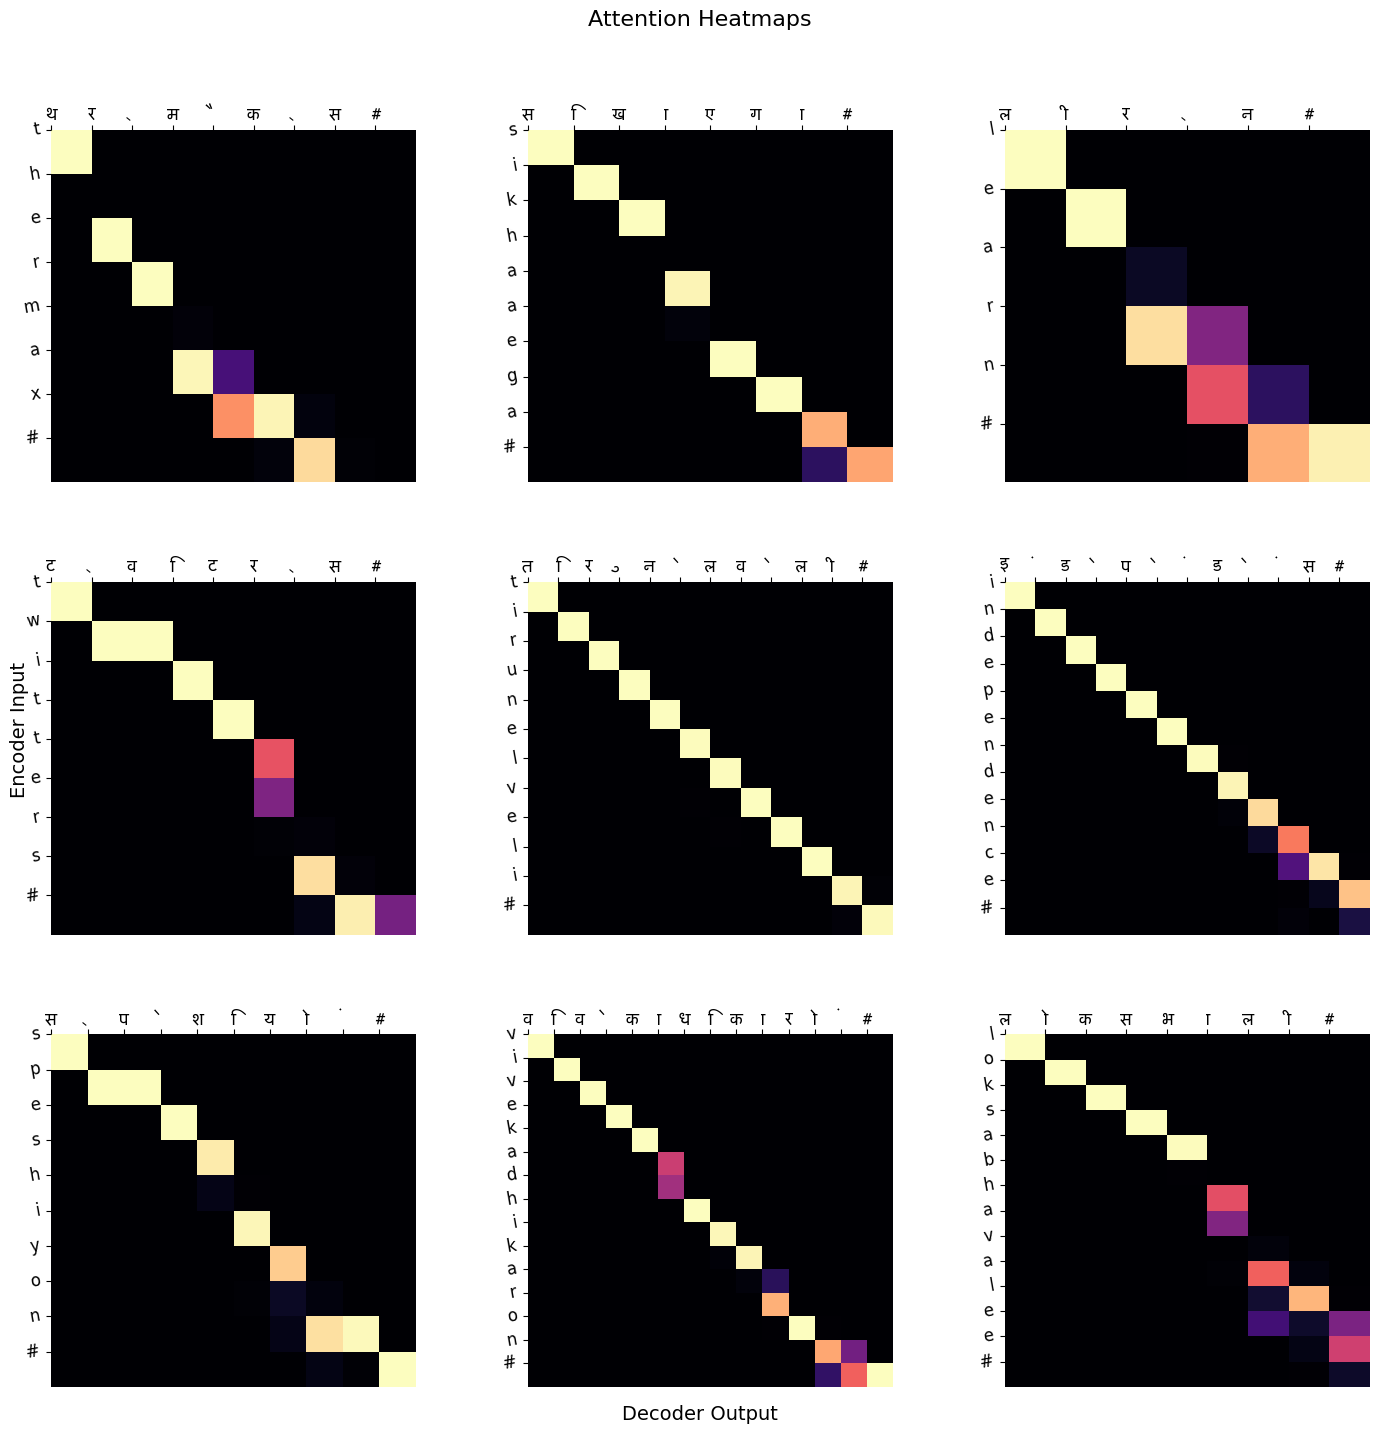

In [34]:
idx_list = [0, 1, 2, 3, 4, 5, 6, 127, 128]
sample_source = torch.zeros(len(idx_list), max_src_len, dtype=torch.long)
sample_target = torch.zeros(len(idx_list), max_tgt_len, dtype=torch.long)

i = 0
for idx in idx_list:
    b_idx = int(np.floor(idx/batch_size))
    d_idx = idx - (b_idx * batch_size)
    sample = next(itertools.islice(test_dataloader, b_idx, None))
    sample_source[i] = sample[0][d_idx]
    sample_target[i] = sample[1][d_idx]
    i += 1

plotAttn(model, sample_source, sample_target, x_vocab, y_vocab)
wandb.finish()